In [1]:
library(dplyr)
library(ggplot2)
library(tibble)
library(haven)
library(Hmisc)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: 'Hmisc'

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units



In [2]:
Blackscholes=function(strike,risk_free,sigma,T,S0,n,type="C")
    {
        if(type=="C")
        {
          d1 <- (log(S0/strike) + (risk_free + sigma^2/2)*T) / (sigma*sqrt(T))
          d2 <- d1 - sigma*sqrt(T)
          value <- S0*pnorm(d1) - strike*exp(-risk_free*T)*pnorm(d2)
          return(value/n)
        }
        if(type=="P")
        {
          d1 <- (log(S0/strike) + (risk_free + sigma^2/2)*T) / (sigma*sqrt(T))
          d2 <- d1 - sigma*sqrt(T)

          value <-  (strike*exp(-risk_free*T)*pnorm(-d2) - S0*pnorm(-d1))
          return(value/n)
        }
    }

In [3]:
Monte_carlo=function(sim=1000000,strike,risk_free, sigma,T, S0,n=1) 
    {

        # Simulation
        ST = S0*exp((risk_free - 0.5*sigma^2)*T + sigma*sqrt(T) * rnorm(sim))

        # Quyen chon Call
        # Tinh chiet khau
        C_payoffs <- (exp(-risk_free*T)*pmax(ST-strike,0))/n
        # Mean va SD cua tap ket qua
        C_Mean <- mean(C_payoffs)
        C_SD <- sd(C_payoffs)/sqrt(sim)


        # Quyen chon Put
        # Tinh chiet khau
        P_payoffs <- (exp(-risk_free*T)*pmax(strike-ST,0))/n
        # Mean va SD cua tap ket qua
        P_Mean <- mean(P_payoffs)
        P_SD <- sd(P_payoffs)/sqrt(sim)
    
    
        # Xuat ket qua 
        Mean=c(C_Mean,P_Mean)
        SD=c(C_SD,P_SD)
        Type=c("Call","Put")
        TrueValue=c(Blackscholes(strike,risk_free,sigma,T,S0,n,"C"),Blackscholes(strike,risk_free,sigma,T,S0,n,"P"))
        tibble(Mean,SD,Type=as_factor(Type),TrueValue=TrueValue,n=sim,method="Simple")
    }

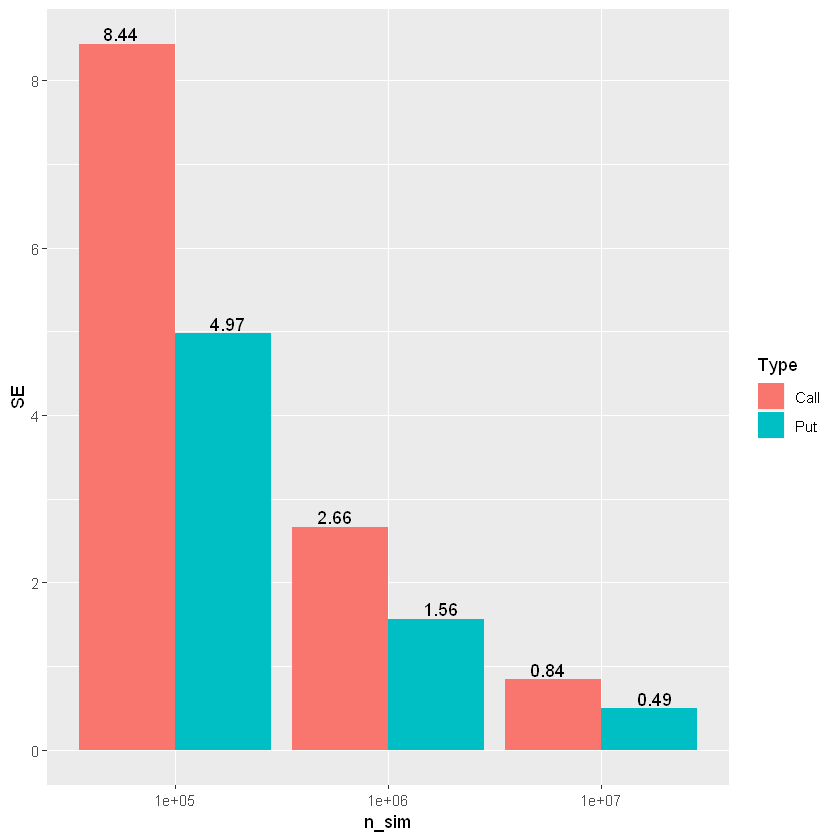

In [4]:
set.seed(1)
#CMWG2104
BS3=Monte_carlo(sim=10000000, T=284/365, risk_free=0.045, sigma=0.2972, S0=137000, strike=135000,n=10)
BS2=Monte_carlo(sim=1000000, T=284/365, risk_free=0.045, sigma=0.2972, S0=137000, strike=135000,n=10)
BS1=Monte_carlo(sim=100000, T=284/365, risk_free=0.045, sigma=0.2972, S0=137000, strike=135000,n=10)
BS=rbind(BS1,BS2,BS3)
ggplot(BS,aes(y=SD,x=factor(n),fill=Type))+geom_col(position="dodge")+geom_text(aes(label=round(SD,2)),vjust=-0.25,position = position_dodge(width = 1))+labs(x="n_sim",y="SE")

In [5]:
Monte_carlo_av=function(sim=1000000,strike,risk_free, sigma,T, S0,n=1) 
    {

        # Simulation
        r=rnorm(sim)
        ST1 = S0*exp((risk_free - 0.5*sigma^2)*T + sigma*sqrt(T)*r)
        # Antithetic path
        ST2 = S0*exp((risk_free - 0.5*sigma^2)*T + sigma*sqrt(T)*(-r))
        
        # Quyen chon Call
        # Tinh chiet khau
        C_payoffs_1 <- (exp(-risk_free*T)*pmax(ST1-strike,0))/n
        C_payoffs_2 <- (exp(-risk_free*T)*pmax(ST2-strike,0))/n
        C_payoffs=(C_payoffs_1+C_payoffs_2)/2
        # Mean va SD cua tap ket qua
        C_Mean <- mean(C_payoffs)
        C_SD <- sd(C_payoffs)/sqrt(sim)


        # Quyen chon Put
        # Tinh chiet khau
        P_payoffs_1 <- (exp(-risk_free*T)*pmax(strike-ST1,0))/n
        P_payoffs_2 <- (exp(-risk_free*T)*pmax(strike-ST2,0))/n
        P_payoffs=(P_payoffs_1+P_payoffs_2)/2
        # Mean va SD cua tap ket qua
        P_Mean <- mean(P_payoffs)
        P_SD <- sd(P_payoffs)/sqrt(sim)
    
    
        # Xuat ket qua 
        Mean=c(C_Mean,P_Mean)
        SD=c(C_SD,P_SD)
        Type=c("Call","Put")
        TrueValue=c(Blackscholes(strike,risk_free,sigma,T,S0,n,"C"),Blackscholes(strike,risk_free,sigma,T,S0,n,"P"))
        tibble(Mean,SD,Type=as_factor(Type),TrueValue=TrueValue,n=sim,method="Antithetic variates")
    }

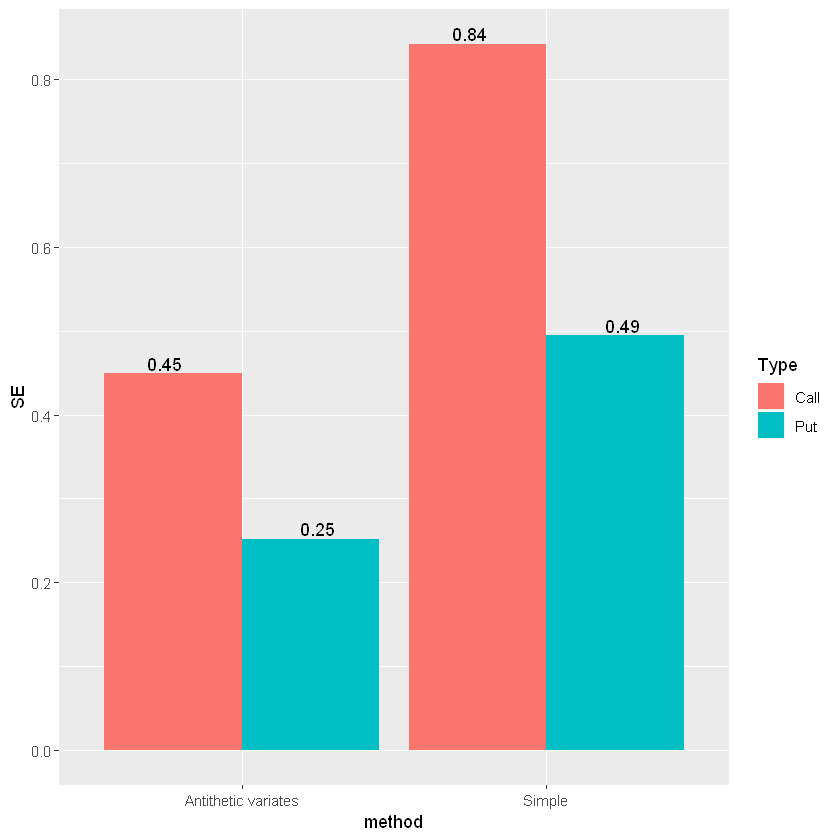

In [6]:
set.seed(1)
#CMWG2104
BS1=Monte_carlo_av(sim=10000000, T=284/365, risk_free=0.045, sigma=0.2972, S0=137000, strike=135000,n=10)
BS2=Monte_carlo(sim=10000000, T=284/365, risk_free=0.045, sigma=0.2972, S0=137000, strike=135000,n=10)
BS=rbind(BS1,BS2)
ggplot(BS,aes(y=SD,x=method,fill=Type))+geom_col(position="dodge")+geom_text(aes(label=round(SD,2)),vjust=-0.25,position = position_dodge(width = 1))+labs(x="method",y="SE")